In [1]:
#.libPaths(c("/home/data/refdir/Rlib","/home/data/t060324/R/x86_64-pc-linux-gnu-library/4.1"))
library(scibet)
library(Seurat)
library(scater)
library(scran)
library(dplyr)
library(Matrix)
library(cowplot)
library(ggplot2)
library(harmony)
rm(list = ls())
gc()
setwd('/home/data/t060324/jobs/aimin/')
library(Seurat)

Registered S3 method overwritten by 'spatstat.core':
  method          from
  formula.glmmPQL MASS

Attaching SeuratObject

Attaching sp

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumpro

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7815418,417.4,15352818,820.0,10562781,564.2
Vcells,13318819,101.7,21771392,166.2,15143229,115.6


## 1.Pre-processing

In [4]:
file.dir <- './data/GSE191301_RAW/'

In [5]:
samplefile <- list.files(file.dir)
samplefile

[1] "GSM5743307_Pre-NACT1A_barcodes.tsv.gz" 
 [2] "GSM5743307_Pre-NACT1A_features.tsv.gz" 
 [3] "GSM5743307_Pre-NACT1A_matrix.mtx.gz"   
 [4] "GSM5743308_Pre-NACT1B_barcodes.tsv.gz" 
 [5] "GSM5743308_Pre-NACT1B_features.tsv.gz" 
 [6] "GSM5743308_Pre-NACT1B_matrix.mtx.gz"   
 [7] "GSM5743309_Pre-NACT1C_barcodes.tsv.gz" 
 [8] "GSM5743309_Pre-NACT1C_features.tsv.gz" 
 [9] "GSM5743309_Pre-NACT1C_matrix.mtx.gz"   
[10] "GSM5743310_Post-NACT1D_barcodes.tsv.gz"
[11] "GSM5743310_Post-NACT1D_features.tsv.gz"
[12] "GSM5743310_Post-NACT1D_matrix.mtx.gz"  
[13] "GSM5743311_Post-NACT1E_barcodes.tsv.gz"
[14] "GSM5743311_Post-NACT1E_features.tsv.gz"
[15] "GSM5743311_Post-NACT1E_matrix.mtx.gz"  
[16] "GSM5743312_Post-NACT1F_barcodes.tsv.gz"
[17] "GSM5743312_Post-NACT1F_features.tsv.gz"
[18] "GSM5743312_Post-NACT1F_matrix.mtx.gz"

In [7]:
barcodes_file <- samplefile[grepl('barcodes.tsv.gz',samplefile)]
features_file <- samplefile[grepl('features.tsv.gz',samplefile)]
mtx_file <- samplefile[grepl('matrix.mtx.gz',samplefile)]
names(barcodes_file) <- substr(barcodes_file,1,10)
names(features_file) <- substr(features_file,1,10)
names(mtx_file) <- substr(mtx_file,1,10)
mtx_file
features_file
barcodes_file

GSM5743307                             GSM5743308 
 "GSM5743307_Pre-NACT1A_matrix.mtx.gz"  "GSM5743308_Pre-NACT1B_matrix.mtx.gz" 
                            GSM5743309                             GSM5743310 
 "GSM5743309_Pre-NACT1C_matrix.mtx.gz" "GSM5743310_Post-NACT1D_matrix.mtx.gz" 
                            GSM5743311                             GSM5743312 
"GSM5743311_Post-NACT1E_matrix.mtx.gz" "GSM5743312_Post-NACT1F_matrix.mtx.gz"

GSM5743307 
 "GSM5743307_Pre-NACT1A_features.tsv.gz" 
                              GSM5743308 
 "GSM5743308_Pre-NACT1B_features.tsv.gz" 
                              GSM5743309 
 "GSM5743309_Pre-NACT1C_features.tsv.gz" 
                              GSM5743310 
"GSM5743310_Post-NACT1D_features.tsv.gz" 
                              GSM5743311 
"GSM5743311_Post-NACT1E_features.tsv.gz" 
                              GSM5743312 
"GSM5743312_Post-NACT1F_features.tsv.gz"

GSM5743307 
 "GSM5743307_Pre-NACT1A_barcodes.tsv.gz" 
                              GSM5743308 
 "GSM5743308_Pre-NACT1B_barcodes.tsv.gz" 
                              GSM5743309 
 "GSM5743309_Pre-NACT1C_barcodes.tsv.gz" 
                              GSM5743310 
"GSM5743310_Post-NACT1D_barcodes.tsv.gz" 
                              GSM5743311 
"GSM5743311_Post-NACT1E_barcodes.tsv.gz" 
                              GSM5743312 
"GSM5743312_Post-NACT1F_barcodes.tsv.gz"

In [18]:
GSE191301List = lapply(names(mtx_file),function(sampleName){
  barcodes.dir <- paste0(file.dir,barcodes_file[sampleName])
    features.dir <- paste0(file.dir,features_file[sampleName])
    mtx.dir <- paste0(file.dir,mtx_file[sampleName])
    barcode.table <- read.csv(file = barcodes.dir,header = F,sep = '\t')
    features.table <- read.csv(file = features.dir,header = F,sep='\t')
    exp <- readMM(file = mtx.dir)
    colnames(exp) <- barcode.table[,1]
    rownames(exp) <- features.table[,2]
   res<- CreateSeuratObject(counts = exp, 
                     project = sampleName)
    res
})

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


In [21]:
names(GSE191301List) <- names(mtx_file)

In [19]:
SeuratPreTreatment <- function(obj=NULL,counts,metadata,QC=FALSE,nCount_cut=500,nFeature_cut=200,log10GenesPerUMI_cut=0.8,mitoRatio_cut=0.2){
    if(is.null(obj)){
        obj <- CreateSeuratObject(counts,meta.data = metadata)
    }
    obj$mitoRatio <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    obj$mitoRatio <- obj@meta.data$mitoRatio / 100
    obj$log10GenesPerUMI <- log10(obj$nFeature_RNA)/log10(obj$nCount_RNA)
    obj$riboRatio <- PercentageFeatureSet(object = obj, pattern = "^RP[SL]")
    obj$riboRatio <- obj@meta.data$mitoRatio / 100
    if(QC){
        filtered_obj <- subset(x = obj, subset= (nCount_RNA >= nCount_cut) & 
                          (nFeature_RNA >= nFeature_cut) & 
                          (log10GenesPerUMI > log10GenesPerUMI_cut) & 
                          (mitoRatio < mitoRatio_cut))
        print(dim(filtered_obj))
        filtered_obj <- NormalizeData(filtered_obj, normalization.method = "LogNormalize")
        filtered_obj <- FindVariableFeatures(filtered_obj, selection.method = "vst", nfeatures = 3000)
        filtered_obj <- ScaleData(filtered_obj, vars.to.regress = c('nCount_RNA'))
        filtered_obj <- RunPCA(filtered_obj)
        filtered_obj <- RunUMAP(filtered_obj,reduction = "pca",dims = 1:30,seed.use = 12345)
        filtered_obj <- FindNeighbors(filtered_obj,reduction = 'pca', dims = 1:30, verbose = FALSE)
        filtered_obj <- FindClusters(filtered_obj,resolution = 0.5, verbose = FALSE,random.seed=20210707)
        return(filtered_obj)
    }else{
        obj <- NormalizeData(obj, normalization.method = "LogNormalize")
        obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 3000)
        obj <- ScaleData(obj, vars.to.regress = c('nCount_RNA'))
        obj <-  RunPCA(obj)
        obj <- RunUMAP(obj,reduction = "pca",dims = 1:30,seed.use = 12345)
        obj <- FindNeighbors(obj,reduction = 'pca', dims = 1:30, verbose = FALSE)
        obj <- FindClusters(obj,resolution = 0.5, verbose = FALSE,random.seed=20210707)
        return(obj)
    }
    

}

In [22]:
GSE191301List <- lapply(GSE191301List,FUN = function(x){
    SeuratPreTreatment(obj = x,QC=T)
})


[1] 27984  4525


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  CALD1, TPM2, CNN3, IGFBP2, THY1, MYL9, PXDN, COL6A1, COL6A2, CPE 
	   C1R, ENAH, RARRES2, CYR61, FSTL1, MXRA8, TPM1, FKBP10, MFAP2, SPARC 
	   CPXM1, CCDC80, PBX1, CTTN, COL3A1, PTK7, CAVIN1, S100A13, PPFIBP1, C1S 
Negative:  SRGN, FCER1G, AIF1, CD68, C1QA, C1QC, C1QB, FCGR3A, CD14, HLA-DRA 
	   HLA-DRB1, HLA-DPA1, LYZ, CYBB, MS4A7, TREM2, VSIG4, APOC1, HLA-DQA1, MSR1 
	   CD83, HLA-DPB1, FCGR2B, SERPINA1, GPR183, PLEK, HLA-DQB1, SPP1, CD163, LILRB4 
PC_ 2 
Positive:  COL5A2, EMILIN1, MMP2, DCN, COL1A2, THBS2, COL6A3, COL5A1, COL1A1, FN1 
	   LUM, BGN, CDH11, FAP, CTHRC1, COL8A1, FBLN1, PRRX1, CFH, AEBP1 
	   MXRA5, CLEC11A, RCN3, LAMB1, FBN1, MGP, COL6A2, COL14A1, SULF1, POSTN 
Negative:  EPCAM, CLDN3, TACSTD2, CLDN4, CLDN7, ELF3, S100A14, KRT7, BCAM, WFDC2 
	   CLDN6, MSLN, KCNK15, MAL2, MUC16, C1orf186, RAB25, MUC1, SLPI, WNT6 
	   C19orf33, LCN2, TNNT2, PCP4, SNCG, SMIM22, S100A1, KRTCAP3, NSG1, ATP6V1B

[1] 27984  7159


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  FCGR3A, CYBB, FCER1G, TYROBP, AIF1, CD68, CD14, PSAP, FN1, FPR3 
	   MAFB, SERPINA1, SLC11A1, LYZ, FCGR2A, SPI1, CTSB, MSR1, MARCKS, MS4A6A 
	   MS4A7, CTSL, CD163, LST1, GLUL, MARCO, FTL, GRN, VSIG4, LYN 
Negative:  LTB, C12orf75, TRBC1, CD7, NKG7, GZMH, CTSW, HMGB2, PRF1, CD8A 
	   CD69, CD8B, H2AFZ, IL7R, STMN1, CD27, KIF2A, DUT, IL2RB, TIGIT 
	   ITM2C, HIST1H4C, LINC01871, PTTG1, TCF7, SOCS1, PPA1, MATK, XCL2, CXCR6 
PC_ 2 
Positive:  KRT8, KRT18, KRT7, MYL9, KRT19, CRABP2, WFDC2, SNCG, IFI27, TPM1 
	   IFITM3, ID4, S100A13, TPM2, ELF3, ADIRF, TPM4, HSPB1, BEX3, CD24 
	   CRABP1, TAGLN, RAB25, CALD1, TPD52L1, CRYAB, S100A16, PAWR, C19orf33, S100A14 
Negative:  VIM, MT-ND4, MT-ND1, UBB, EMP3, ALOX5AP, NKG7, MT-ND2, LTB, SRGN 
	   TRBC1, ITGB2, CD69, MT-ND5, CTSC, GZMH, CTSW, CD7, LAPTM5, PRF1 
	   CD8A, CCL4, NEAT1, GBP5, CD8B, HLA-DPB1, HLA-DRB1, HLA-DPA1, SOCS1, LINC01871 
PC_ 3 
Positive:  LGALS2, DN

[1] 27984  5243


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  KRT18, KRT8, BCAM, MYL9, EPCAM, MSLN, ADIRF, ID4, CLU, KRT19 
	   CLDN3, KRT7, TACSTD2, WFDC2, PAWR, S100A13, TJP1, SLPI, NR2F6, ELF3 
	   MUC16, CALD1, PCP4, CLDN4, SNCG, AKAP12, CLDN7, EMP2, PBX1, TPM2 
Negative:  SRGN, TYROBP, FCER1G, AIF1, VIM, CD68, C1QA, C1QC, C1QB, CTSS 
	   CD14, LYZ, HLA-DPA1, FCGR3A, HLA-DRB1, IER3, CYBB, HLA-DPB1, HLA-DQA1, TREM2 
	   MS4A7, PLEK, MS4A6A, FCGR2B, HLA-DRA, HLA-DQB1, LST1, SERPINA1, CSF1R, VSIG4 
PC_ 2 
Positive:  TRBC2, RPL35A, RPL18A, TSTD1, LTB, CLDN3, S100A14, EPCAM, RPS28, RPS18 
	   TACSTD2, KRT7, CLDN4, RAB25, PCP4, RPL8, CLDN7, XCL2, NSG1, ELF3 
	   MAL2, SLPI, KRTCAP3, TMEM238, IFNG, C19orf33, CD7, ISG20, WFDC2, KLK5 
Negative:  MGP, SPARC, COL5A2, COL1A2, SPARCL1, BGN, IGFBP7, DCN, COL1A1, COL6A2 
	   COL6A3, LAMB1, FBN1, COL4A2, LAMA4, PRRX1, COL5A1, LUM, COL4A1, EMILIN1 
	   COX7A1, SNAI2, CD248, CFH, IGFBP4, CDH11, FSTL1, LHFPL6, PDGFRB, CLEC11A 
PC_ 3

[1] 27984  4108


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  FCER1G, RGS1, HLA-DPB1, TYROBP, CD68, AIF1, CTSS, CD14, SPI1, C1QC 
	   MS4A7, FCGR2A, C1QA, MS4A6A, C1QB, CSF1R, CD83, FCGR3A, CYBB, HLA-DPA1 
	   TREM2, PLEK, HLA-DQB1, HLA-DQA1, CD86, HLA-DMB, HLA-DRB1, LILRB4, GPR183, LST1 
Negative:  MYL9, KRT8, S100A13, KRT18, CLU, CALD1, ADIRF, KRT19, ID4, TPM2 
	   CYR61, BCAM, TPM1, PAWR, KRT7, SLPI, BEX3, WFDC2, MARCKSL1, MDK 
	   MSLN, PBX1, CTGF, CLDN3, TACSTD2, NR2F6, CRYAB, CTTN, CNN3, EPCAM 
PC_ 2 
Positive:  COL5A2, COL1A2, COL6A3, COL1A1, DCN, LUM, MMP2, AEBP1, COL5A1, FAP 
	   CTHRC1, THBS2, BGN, EMILIN1, COL8A1, COL3A1, COL6A2, COL14A1, CDH11, FBLN1 
	   PRRX1, MGP, PDLIM3, COL12A1, SPARC, SPARCL1, POSTN, COL16A1, RCN3, MXRA5 
Negative:  CLDN3, KRT7, MSLN, CLDN7, TACSTD2, RAB25, EPCAM, ELF3, WFDC2, C19orf33 
	   CLDN4, SLPI, BCAM, SPINT2, KCNK15, S100A14, MAL2, KLK5, MUC16, PCP4 
	   SMIM22, CD24, FXYD3, TSTD1, ATP6V1B1, LCN2, KRT19, ERBB3, S100A1, SCARA3

[1] 27984  4091


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  KRT18, BCAM, KRT8, MSLN, ADIRF, KRT7, CLU, ID4, MYL9, KRT19 
	   TACSTD2, WFDC2, PAWR, SLPI, CLDN4, CLDN3, EPCAM, ELF3, S100A13, C19orf33 
	   CALD1, MUC16, TPM1, PBX1, TM4SF1, KLK7, C1orf186, EMP2, MFGE8, SNCG 
Negative:  SRGN, VIM, FCER1G, TYROBP, HLA-DPB1, AIF1, CCL3, HLA-DPA1, HLA-DQA1, SPI1 
	   HLA-DRB1, IER3, MS4A7, C1QA, C1QC, TREM2, COTL1, CD68, C1QB, HSPA1A 
	   PLEK, CD14, MS4A6A, CSF1R, CCL3L3, CD83, FCGR2A, RGS10, CYBB, HLA-DMB 
PC_ 2 
Positive:  TRAC, GZMA, NKG7, TRBC2, IL32, TRBC1, GZMH, LTB, GZMK, CD8A 
	   CTSW, CD247, XCL2, CD8B, CD7, ZNF683, PRF1, LINC01871, DUSP4, IL2RB 
	   SH2D2A, TRGC2, C12orf75, IFNG, TSTD1, GZMB, FASLG, CXCR6, SOCS1, RPS18 
Negative:  SPARCL1, COL4A2, COL4A1, ESAM, IGFBP7, GNG11, CD34, SPARC, LAMB1, CAV1 
	   CDH5, CAVIN2, CLEC14A, ECSCR, ADGRL4, IGFBP4, RAMP2, EGFL7, VWF, MGP 
	   NES, ADGRF5, PLVAP, TM4SF18, EMCN, CAV2, KDR, AQP1, MYCT1, A2M 
PC_ 3 
Positive:  IL3

[1] 27984  6251


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  VIM, C1QB, TGFBI, HLA-DRA, CD14, AP1S2, MNDA, LYZ, PLEK, APOC1 
	   CCL3, IER3, SERPINA1, A2M, SPP1, FCGBP, FN1, LGALS1, GPR183, CALHM6 
	   SGK1, CCL3L3, IGSF6, CD83, GPNMB, LMO2, APOE, SOD2, PLAUR, CPVL 
Negative:  KRT8, KRT18, CLU, BCAM, EPCAM, KRT19, MSLN, KRT7, WFDC2, TACSTD2 
	   MUC16, ADIRF, MYL9, NR2F6, CLDN3, PAWR, LAPTM4B, DSP, KCNK15, ID4 
	   ELF3, FHL2, THY1, CCDC80, SLPI, S100A1, CLDN4, PTGDS, TIMP3, PBX1 
PC_ 2 
Positive:  SPARCL1, BGN, COL4A2, MGP, IGFBP7, COL1A2, COL5A2, LAMB1, SPARC, COL1A1 
	   COL4A1, LAMA4, COL6A3, COL6A2, FBN1, MSRB3, COX7A1, PRRX1, PDGFRB, AEBP1 
	   DCN, NID1, LHFPL6, COL3A1, CAV1, CRISPLD2, TWIST1, NREP, COL14A1, ADGRA2 
Negative:  KRT7, CLDN3, TACSTD2, S100A1, ELF3, KCNK15, CLDN4, LCN2, WFDC2, SLPI 
	   RAB25, S100A14, EPCAM, PDZK1IP1, CLDN7, MSLN, KRT19, MAL2, LY6G6C, SMIM22 
	   KRTCAP3, C19orf33, MUC16, LY6E, ATP6V1B1, MUC1, TSTD1, NSG1, TMPRSS3, ERBB3 
PC_ 3 


In [23]:
saveRDS(GSE191301List,file = './output/OV_GSE191301List.rds')

In [24]:
names(GSE191301List)

[1] "GSM5743307" "GSM5743308" "GSM5743309" "GSM5743310" "GSM5743311"
[6] "GSM5743312"

In [26]:
OV_GSE191301 <- merge(GSE191301List[[1]],GSE191301List[-1],add.cell.ids = names(GSE191301List))

In [27]:
OV_GSE191301

An object of class Seurat 
27984 features across 31377 samples within 1 assay 
Active assay: RNA (27984 features, 0 variable features)

In [28]:
OV_GSE191301 <- NormalizeData(OV_GSE191301, normalization.method = "LogNormalize")
OV_GSE191301 <- FindVariableFeatures(OV_GSE191301, selection.method = "vst", nfeatures = 2000)
OV_GSE191301 <- ScaleData(OV_GSE191301, vars.to.regress = c('nCount_RNA','mitoRatio'))

Warning message:
“Requested variables to regress not in object: percent.mt”
Regressing out nCount_RNA

Centering and scaling data matrix



In [29]:
OV_GSE191301 <- RunPCA(OV_GSE191301)

PC_ 1 
Positive:  MYL9, KRT18, KRT8, CALD1, BCAM, ADIRF, CLU, ID4, MSLN, KRT19 
	   S100A13, KRT7, PAWR, TACSTD2, EPCAM, CLDN3, SLPI, TM4SF1, WFDC2, ELF3 
	   CLDN4, TIMP3, TJP1, TPM2, TPM1, PBX1, MUC16, CYR61, AKAP12, MFGE8 
Negative:  HLA-DPB1, HLA-DPA1, CD68, HLA-DQA1, FCGR3A, CD14, C1QC, C1QA, C1QB, LYZ 
	   PLEK, HLA-DRA, TREM2, AP1S2, VSIG4, EMP3, SERPINA1, FCGR2B, LILRB4, MNDA 
	   CD163, APOC1, SPP1, FPR3, GPR183, MS4A4A, OLR1, CALHM6, TGFBI, HMOX1 
PC_ 2 
Positive:  COL5A2, COL1A2, DCN, COL6A3, COL1A1, LUM, COL5A1, BGN, MGP, THBS2 
	   CTHRC1, EMILIN1, AEBP1, FAP, PRRX1, LAMB1, CDH11, COL8A1, COL6A2, SPARC 
	   SPARCL1, MMP2, FBLN1, COL3A1, COL14A1, CFH, SULF1, FBN1, COL4A2, MXRA5 
Negative:  CLDN3, TACSTD2, KRT7, CLDN4, EPCAM, ELF3, MSLN, CLDN7, SLPI, WFDC2 
	   KCNK15, S100A14, MUC16, S100A1, PCP4, C19orf33, RAB25, C1orf186, LY6G6C, MAL2 
	   KLK5, LCN2, ERBB3, KRT19, FXYD3, BCAM, TNNT2, ATP6V1B1, SMIM22, KLK7 
PC_ 3 
Positive:  LTB, XCL2, TIGIT, DUSP4, CD27, GZMB, ICOS, HOP

In [30]:
OV_GSE191301 <- RunUMAP(OV_GSE191301,reduction = "pca",dims = 1:30,seed.use = 12345)
OV_GSE191301 <- FindNeighbors(OV_GSE191301,reduction = 'pca', dims = 1:30, verbose = FALSE)
OV_GSE191301 <- RunTSNE(OV_GSE191301,reduction = 'pca',dims = 1:30,seed.use = 12345)

19:43:27 UMAP embedding parameters a = 0.9922 b = 1.112

19:43:27 Read 31377 rows and found 30 numeric columns

19:43:27 Using Annoy for neighbor search, n_neighbors = 30

19:43:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:43:31 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpKVesik/file1a59b56c1ca9e6

19:43:31 Searching Annoy index using 1 thread, search_k = 3000

19:43:42 Annoy recall = 100%

19:43:43 Commencing smooth kNN distance calibration using 1 thread

19:43:46 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

19:43:46 Initializing from PCA

19:43:46 Using 'irlba' for PCA

19:43:46 PCA: 2 components explained 44.59% variance

19:43:46 Commencing optimization for 200 epochs, with 1406412 positive ed

In [32]:
OV_GSE191301 <- FindClusters(OV_GSE191301,resolution = 0.5, verbose = FALSE,random.seed=20210707)

In [35]:
OV_GSE191301$sampleId <- OV_GSE191301$orig.ident

In [39]:
OV_GSE191301$sample <- OV_GSE191301$sampleId

In [41]:
OV_GSE191301$patient_id <- ''
OV_GSE191301$patient_id  <- ifelse(OV_GSE191301$sample=='GSM5743307','Pre-NACT-A',OV_GSE191301$patient_id)
OV_GSE191301$patient_id  <-ifelse(OV_GSE191301$sample=='GSM5743308','Pre-NACT-B',OV_GSE191301$patient_id)
OV_GSE191301$patient_id  <-ifelse(OV_GSE191301$sample=='GSM5743309','Pre-NACT-C',OV_GSE191301$patient_id)
OV_GSE191301$patient_id  <-ifelse(OV_GSE191301$sample=='GSM5743310','Post-NACT-D',OV_GSE191301$patient_id)
OV_GSE191301$patient_id  <-ifelse(OV_GSE191301$sample=='GSM5743311','Post-NACT-E',OV_GSE191301$patient_id)
OV_GSE191301$patient_id  <-ifelse(OV_GSE191301$sample=='GSM5743312','Post-NACT-F',OV_GSE191301$patient_id)

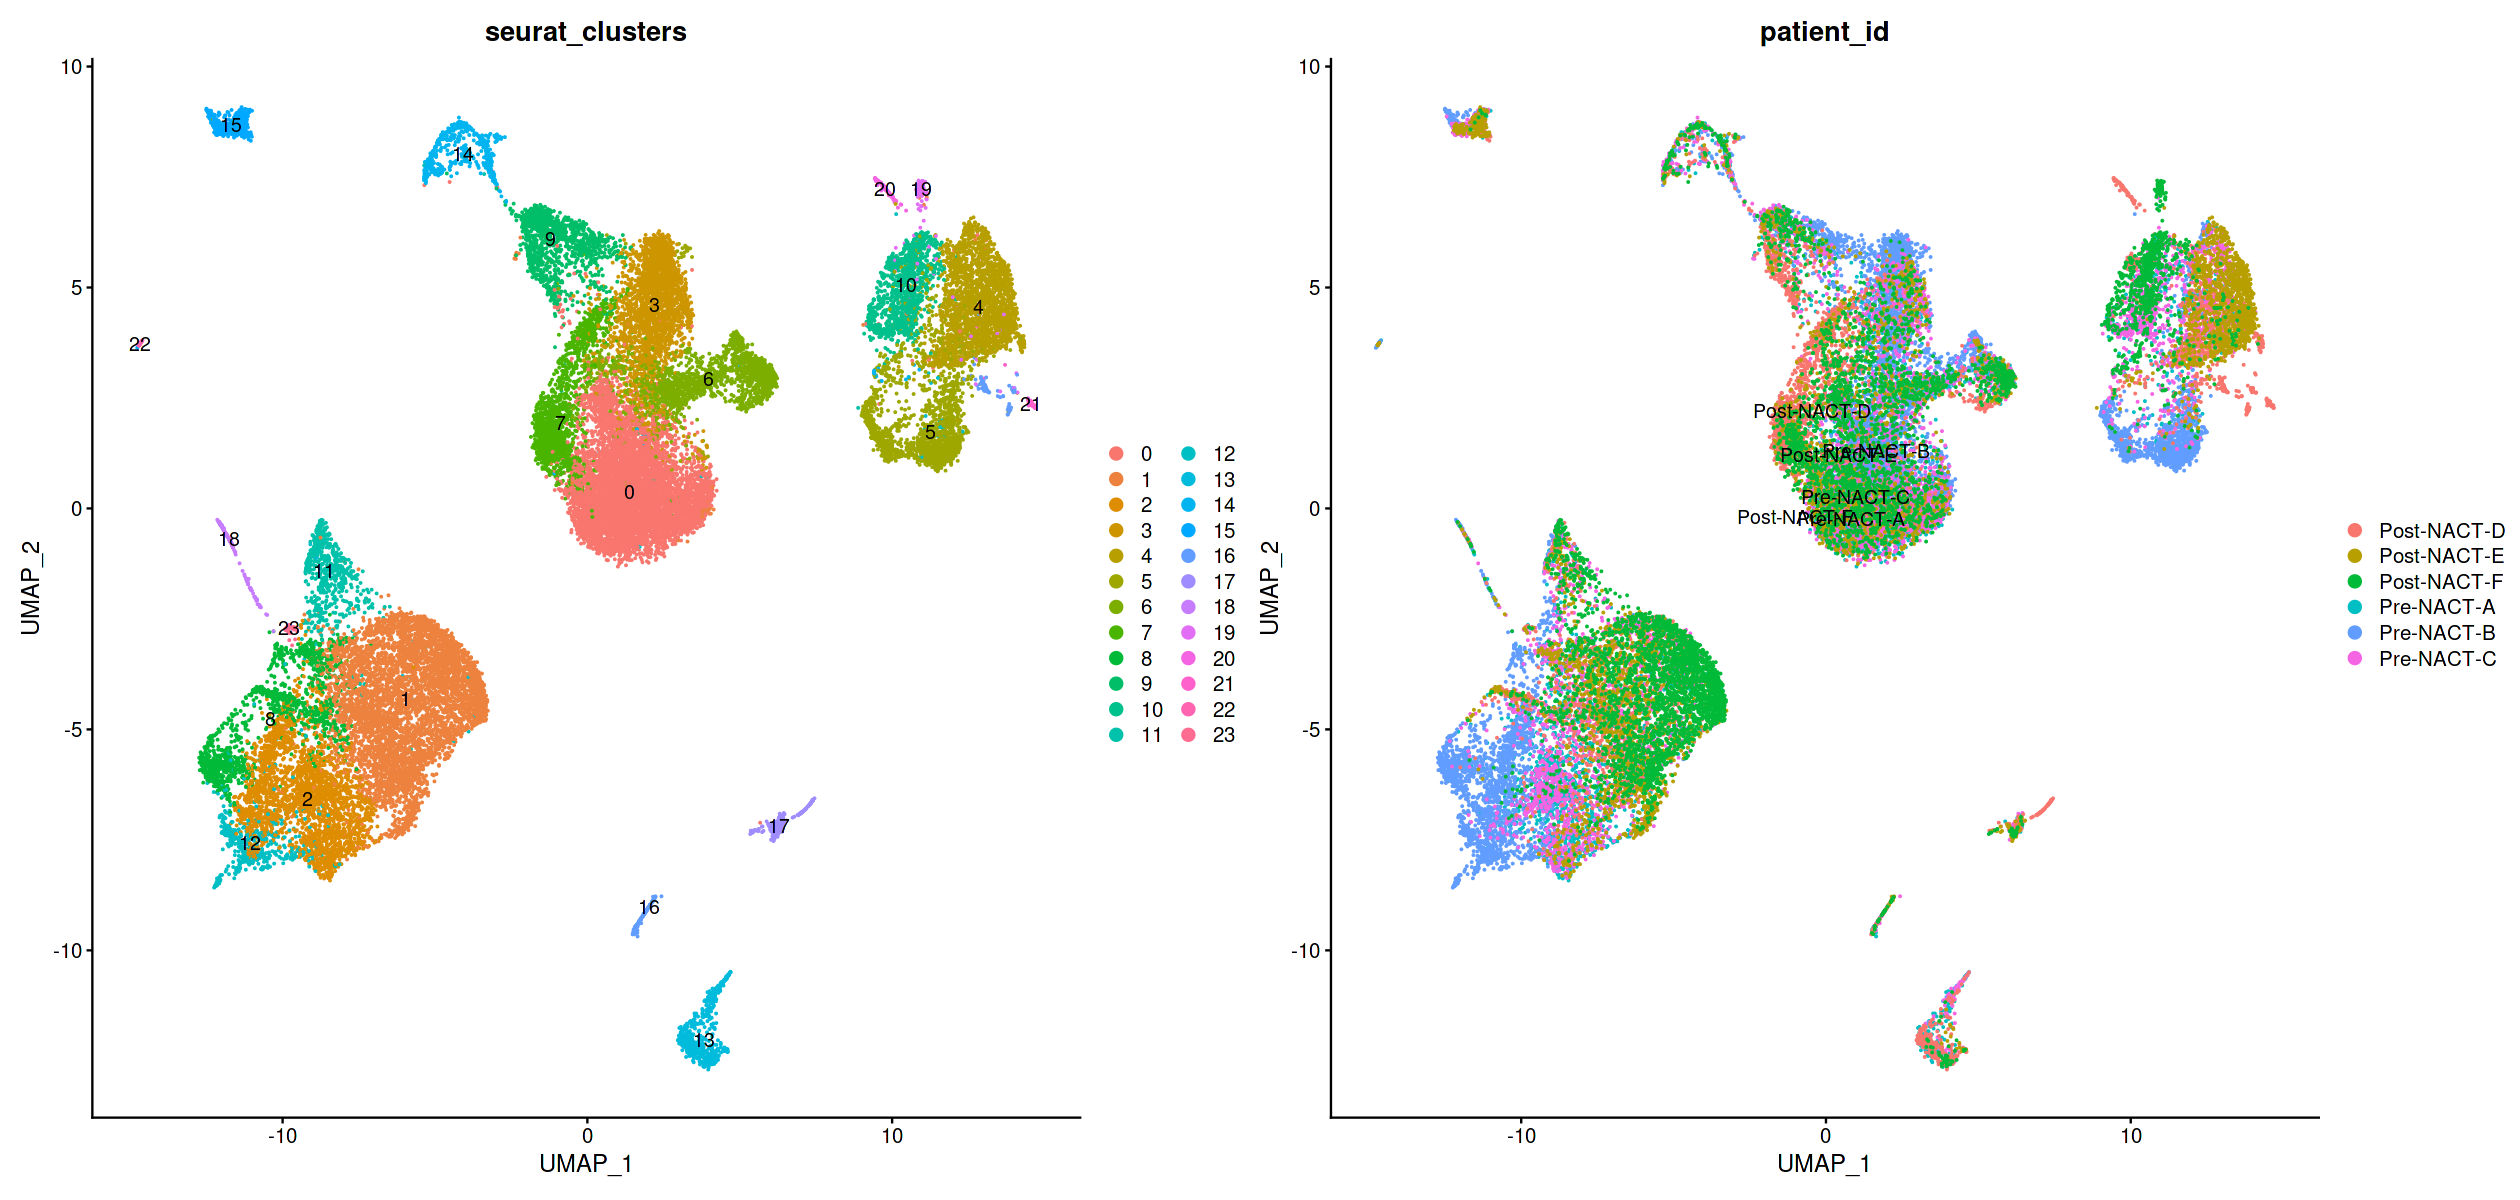

In [42]:
options(repr.plot.height = 10, repr.plot.width = 21)
DimPlot(object = OV_GSE191301,reduction = 'umap',group.by = c('seurat_clusters','patient_id'), label = TRUE)

In [40]:
genes_to_check = c('PTPRC', 'CD3D', 'CD3E', 'CD4','CD8A','TNFRSF18','SLC4A10','IL7R','CXCL13',
                   'CD19', 'CD79A', 'MS4A1' ,'FOS',
                   'IGHG1', 'MZB1', 'SDC1',
                   'CD68', 'CD163', 'CD14', 'JCHAIN',
                   'TPSAB1' , 'TPSB2',  # mast cells,
                   'RCVRN','FPR1' , 'ITGAM' ,
                   'C1QA',  'C1QB',  # mac
                   'S100A9', 'S100A8','CD86', 'MMP19',# monocyte
                   'LAMP3', 'IDO1','IDO2',## DC3 
                   'CD1E','CD1C', # DC2
                   'KRT86','GNLY', # NK 
                   'FGF7','MME', 'ACTA2','CTGF','CCN2','GFPT2', ## fibo 
                   'DCN', 'LUM',  'GSN' , ## mouse PDAC fibo 
                   'FAP','FN1','THY1','COL1A1','COL3A1', 
                   'PECAM1', 'VWF',  ## endo 
                   'EPCAM' , 'KRT19', 'PROM1', 'CD24','MKI67' )
                   

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: CCN2”


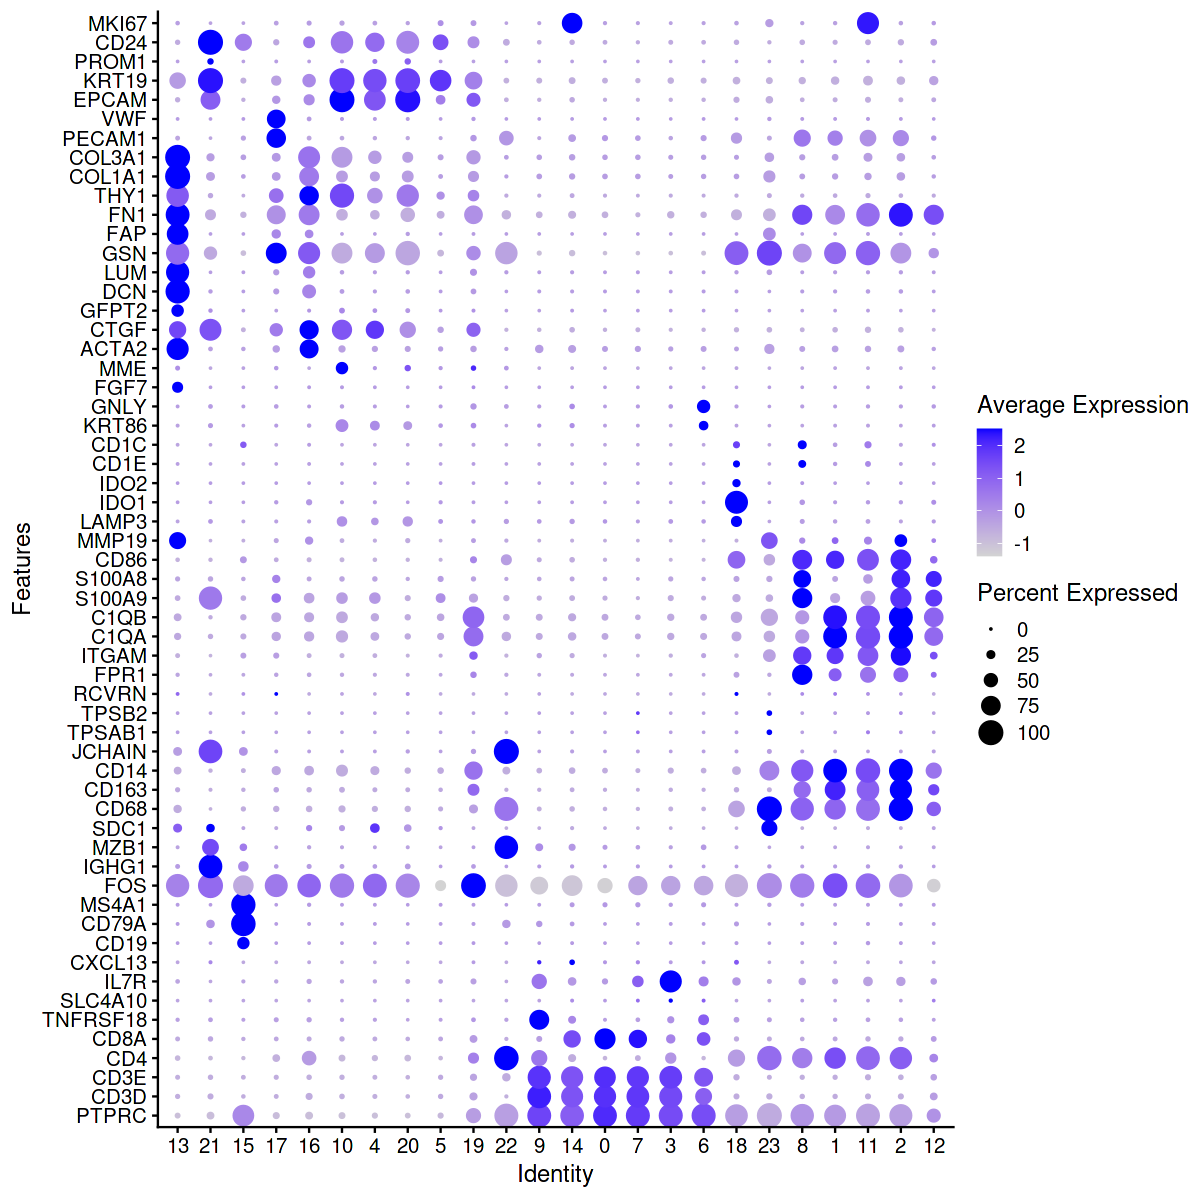

In [41]:
options(repr.plot.height = 10, repr.plot.width = 10)
DotPlot(OV_GSE191301,group.by = 'seurat_clusters', features = unique(genes_to_check),cluster.idents = T) + coord_flip()

## 2.Cell type annotation

In [42]:
cellAnnotation <- function(obj,markerList,assay='SCT',slot='data'){
  markergene <- unique(do.call(c,markerList))

  Idents(obj) <- 'seurat_clusters'
  cluster.averages <- AverageExpression(obj,assays=assay, slot = slot,features=markergene, return.seurat = TRUE)
  if(assay=='SCT'){
    scale.data <- cluster.averages@assays$SCT@data
  }else{
    scale.data <- cluster.averages@assays$RNA@data
  }
  print(scale.data)
  cell_score <- sapply(names(markergeneList),function(x){
    tmp <- scale.data[rownames(scale.data)%in%markergeneList[[x]],]
    if(is.matrix(tmp)){
        if(nrow(tmp)>=2){
            res <- apply(tmp,2,max)
           return(res)
    }else{
        return(rep(-2,ncol(tmp)))
    }
    }else{
        return(tmp)
    }


  })
   print(cell_score)
  celltypeMap <- apply(cell_score,1,function(x){
    colnames(cell_score)[which(x==max(x))]
  },simplify = T)
  obj@meta.data$cellType_auto <- plyr::mapvalues(x = obj@active.ident, from = names(celltypeMap), to = celltypeMap)

  return(obj)
}

In [43]:
EOC <- c('EPCAM','CD24','KRT18')
T_gene <- c('CD3D','CD3E')
myeloid <- c('CD68','CD14','TPSAB1' , 'TPSB2','CD1E','CD1C','LAMP3', 'IDO1')
EOC <- c('EPCAM','KRT19','CD24')
fibo_gene <- c('DCN','FAP','COL1A2')
NK_gene<-c('GNLY','KRT86')
plasma <- c('MZB1','JCHAIN')
B_gene <- c('MS4A1','CD19')
endo_gene <- c('PECAM1','VWF')
 

#markergeneList <- list(EOC=EOC_gene,T=T_gene,MNC=monocyte_gene,B=B_gene,mast=mast_gene,fibo=fibo_gene,endo=endo_gene,ILC=ILC_gene)
markergeneList <- list(T=T_gene,plasma=plasma,B=B_gene,myeloid=myeloid,Epi=EOC,fibo=fibo_gene,endo=endo_gene,NK=NK_gene)
#BRCA_GSE161529_QC <- SeuratPreTreatment(counts=GetAssayData(object = BRCA_GSE161529,assay = 'RNA',slot = 'counts'),metadata=BRCA_GSE161529@meta.data,QC=T)
OV_GSE191301 <- cellAnnotation(obj=OV_GSE191301,assay = 'RNA',markerList=markergeneList)


Centering and scaling data matrix



                 0           1           2           3            4
CD3D   2.372585863 0.227368082 0.175082899 2.201286507 0.0813942005
CD3E   2.180071443 0.189938027 0.136545030 2.087198437 0.0774525381
MZB1   0.162848673 0.007598041 0.008113503 0.049252376 0.0082794815
JCHAIN 0.006073472 0.011307332 0.003137005 0.011738375 0.0041771638
MS4A1  0.215084373 0.014924569 0.009785635 0.069941998 0.0071402345
CD19   0.001847940 0.006470958 0.004959402 0.003203529 0.0004488209
CD68   0.117659612 1.700825378 2.321929199 0.107461783 0.1484785828
CD14   0.301961072 2.981184405 2.951893896 0.265041748 0.4335817219
TPSAB1 0.000000000 0.002852199 0.004826798 0.000000000 0.0000000000
TPSB2  0.000000000 0.002700490 0.008815907 0.000000000 0.0002650584
CD1E   0.001772717 0.031257621 0.009437213 0.001863005 0.0003651837
CD1C   0.003234385 0.041055085 0.012270228 0.004615400 0.0005727924
LAMP3  0.122490557 0.043857183 0.011711307 0.111127674 0.1232871058
IDO1   0.009682931 0.039853899 0.031924495 0.007

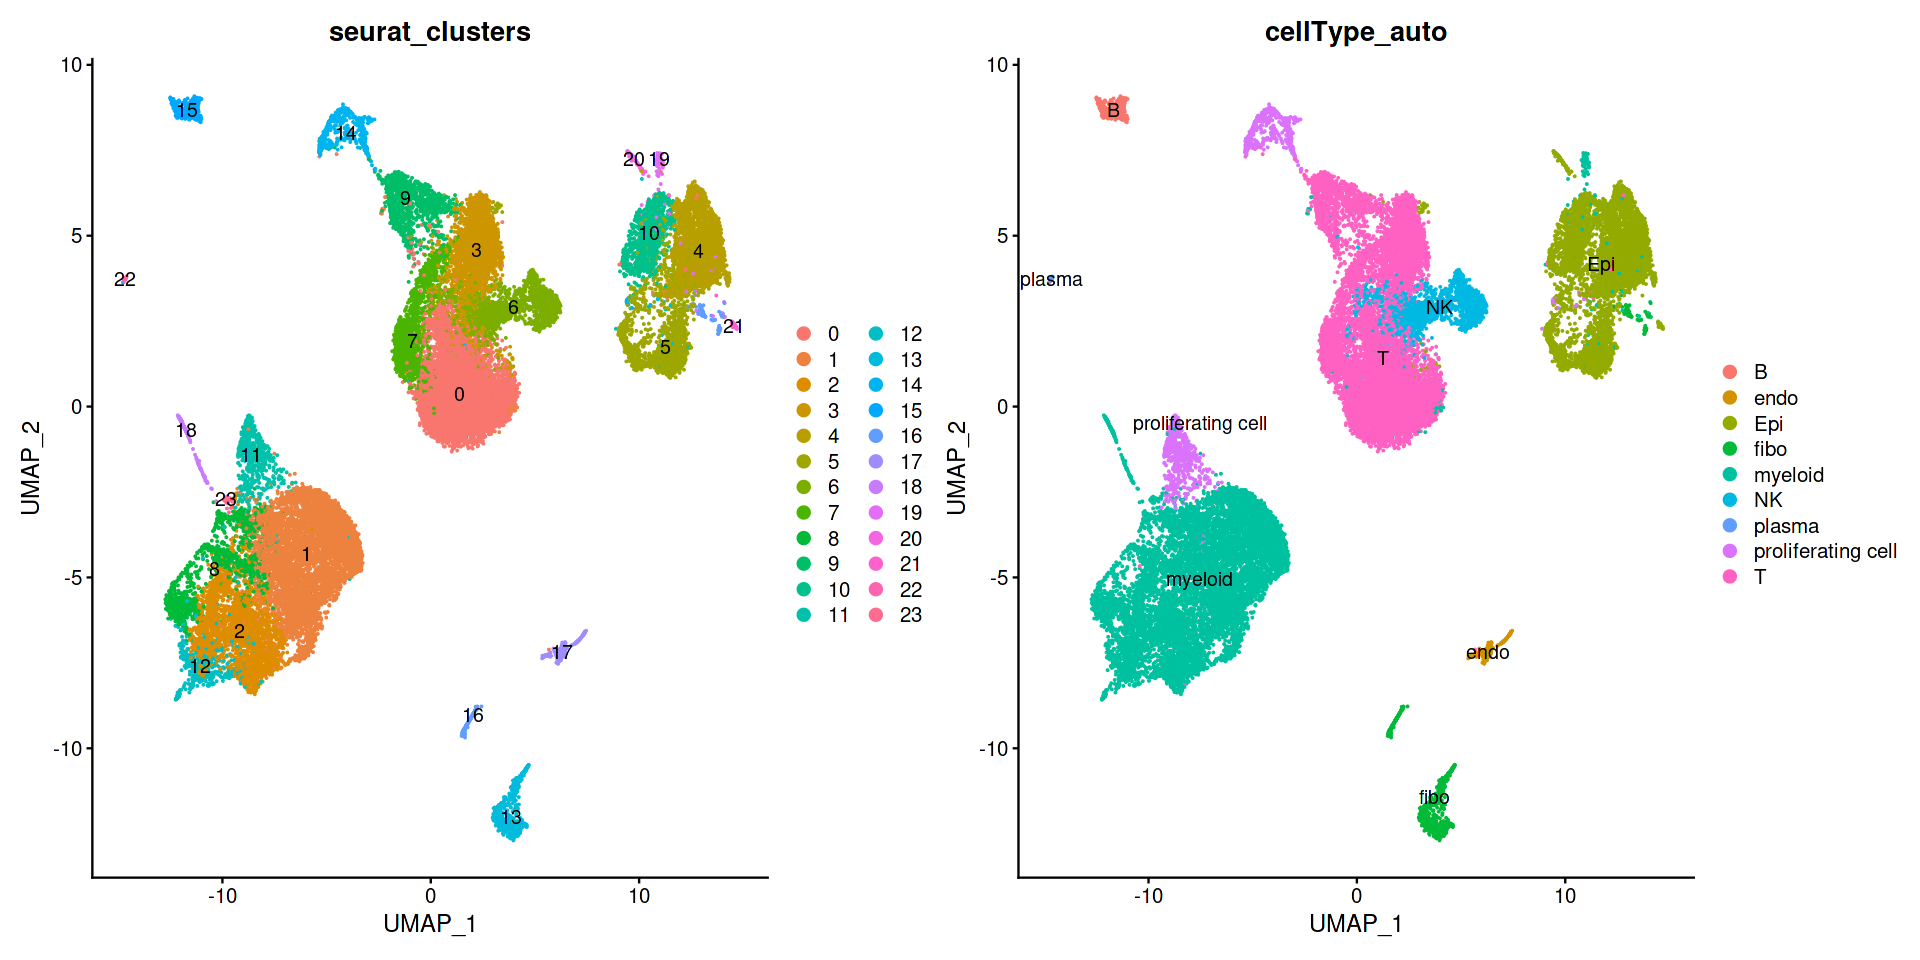

In [25]:
options(repr.plot.height = 8, repr.plot.width = 16)
DimPlot(object = OV_GSE191301,reduction = 'umap',group.by = c('seurat_clusters','cellType_auto'), label = TRUE)

In [24]:
OV_GSE191301$cellType_auto[which(OV_GSE191301$seurat_clusters%in%c(11,14))] <- 'proliferating cell'

## 3.Calculate the AUCell score of the modules

In [45]:
all_signiff_modules_fisher <- readRDS(file = './output/MEGENA/all_signiff_modules_fisher.RDS')
load(file = "./output/MEGENA/summary.TCGA_MEGENA.output.RData")
modules_list <- summary.TCGA_MEGENA.output$modules[all_signiff_modules_fisher]

In [46]:
all_gene <- rownames(OV_GSE191301)

In [47]:
modules_list2 <- list()
for(i in names(modules_list)){
    modules_list2[[i]] <- intersect(modules_list[[i]],all_gene)
}

In [48]:
library(AUCell)

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



 min   1%   5%  10%  50% 100% 
 204  402  615  846 1937 9853 


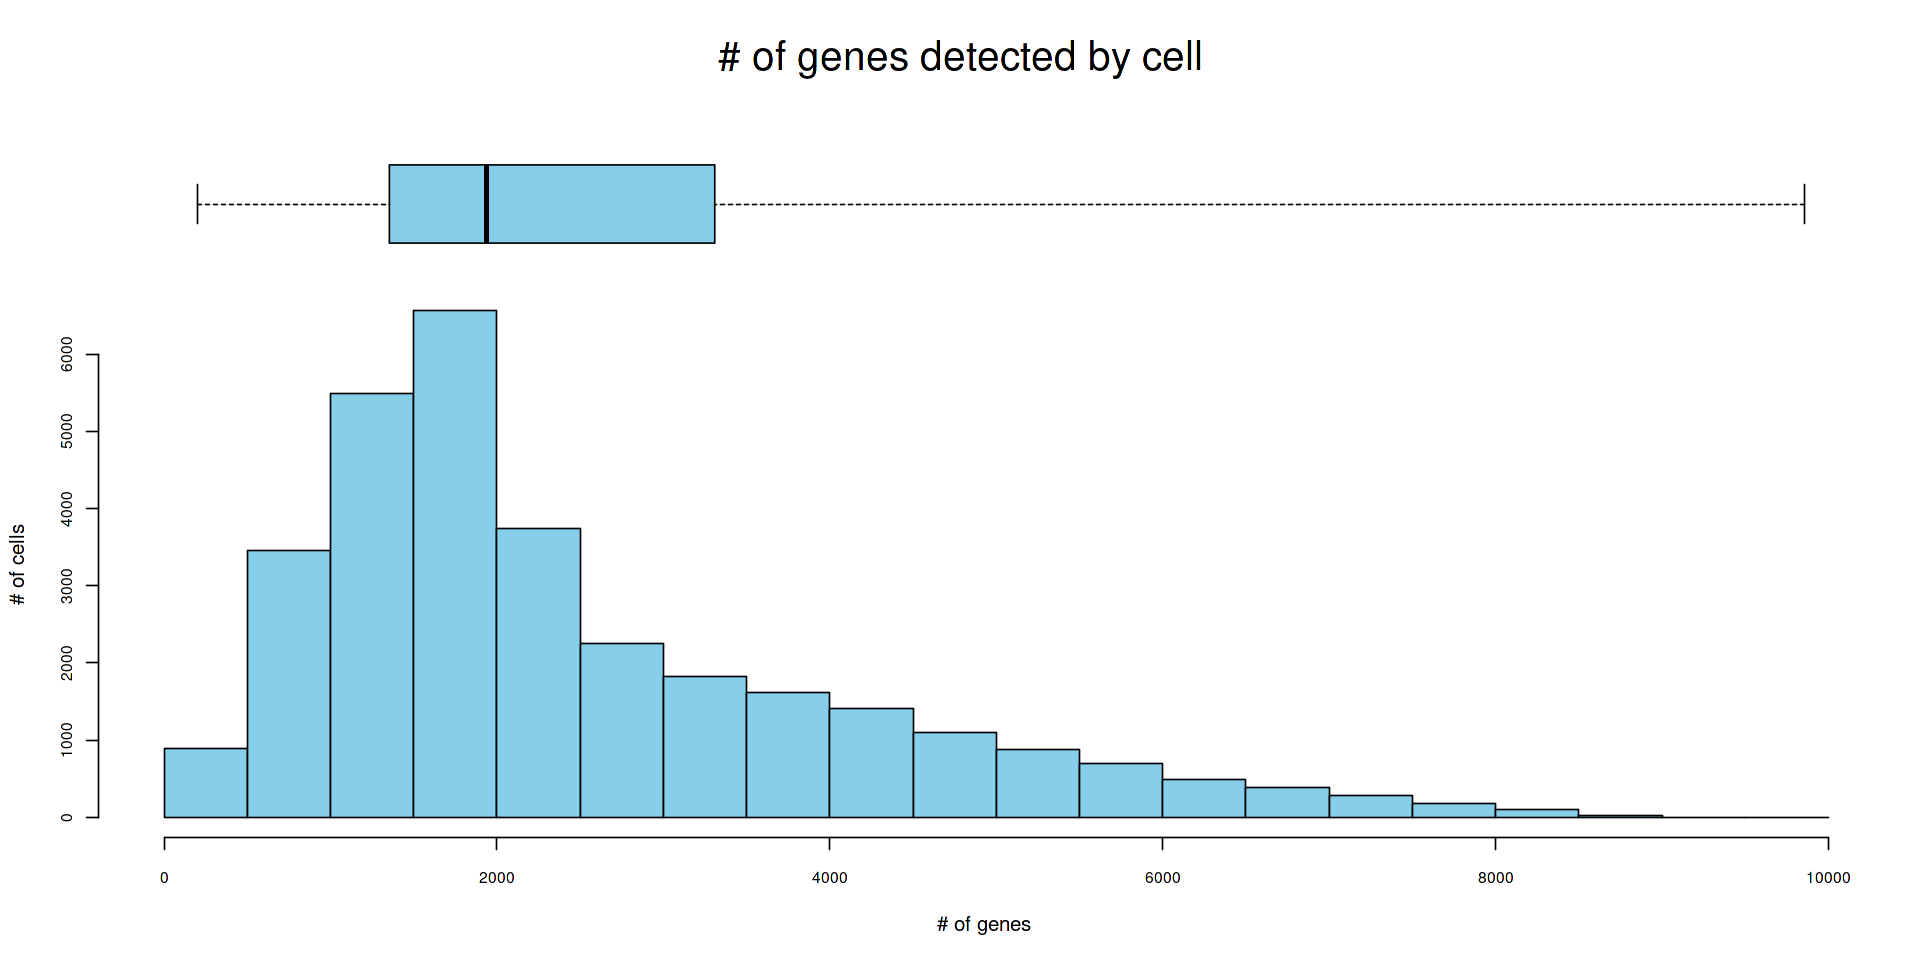

In [49]:
cells_rankings <- AUCell_buildRankings(OV_GSE191301@assays$RNA@data)

In [50]:
cells_AUC <- AUCell_calcAUC(modules_list2, cells_rankings, aucMaxRank=nrow(cells_rankings)*0.1)

In [51]:
moduleScore <- getAUC(cells_AUC)

In [52]:
OV_GSE191301[["module_AUC"]] <- CreateAssayObject(data = moduleScore )

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from module_auc_ to moduleauc_”


In [20]:
DefaultAssay(OV_GSE191301)<- "module_AUC"

In [21]:
##计算某块得分在不同细胞类型中的富集得分
OV_GSE191301$cellType_auto <- as.character(OV_GSE191301$cellType_auto)
scoreE <- rowMeans(OV_GSE191301)
mergeData.list <- SplitObject(object = OV_GSE191301,split.by = 'cellType_auto')
scoreO <- sapply(mergeData.list,rowMeans)
enrichScore <- log2(scoreO/scoreE)

In [22]:
rownames(enrichScore)  <- gsub(pattern = 'c1-',replacement = 'M',rownames(enrichScore))

In [23]:
enrichScore[which(enrichScore<= -1)]=-1
enrichScore[which(enrichScore>1)]=1

In [24]:
gene_fisher <- function(data=GSE183904_merge_224,Subcluster='Subcluster',assay = 'RNA',slot = 'counts',gene=node$name,cellTpye="Fibroblast",cutoff=1){
            fisher_list <- list()
            fibcell <- colnames(data)[which(data@meta.data[,Subcluster] %in% cellTpye)]
            #gene <- intersect(gene,rownames(data))
            fisher <- data.frame(gene=gene,OR=0,P=0,P.adjust=0,number_of_cell_expGene=0,Proportion=0)
            rownames(fisher) <- gene
            exp <- GetAssayData(data,assay = assay,slot = slot)
            for(i in gene){
                if(i %in% rownames(data)){
                    cell_expGene <- names(exp[i,][which(exp[i,]>cutoff)]) 
               fisher_matrix <- matrix(c(length(intersect(fibcell,cell_expGene)),
                              length(cell_expGene)-length(intersect(fibcell,cell_expGene)),
                              length(fibcell)-length(intersect(fibcell,cell_expGene)),
                              ncol(data)-length(cell_expGene)-length(fibcell)+length(intersect(fibcell,cell_expGene))),
                              nrow=2)
                res <- fisher.test(fisher_matrix,alternative='greater')
                fisher[i,'OR'] <- as.vector(res[[3]])
                fisher[i,'P'] <- as.vector(res[[1]])
                fisher[i,'P.adjust'] <- p.adjust(as.vector(res[[1]]),n = length(gene))
                fisher[i,'number_of_cell_expGene'] <- fisher_matrix[1]
                fisher[i,'Proportion'] <- fisher_matrix[1]/(fisher_matrix[1]+fisher_matrix[2])   
                }else{
                fisher[i,'OR'] <- NA
                fisher[i,'P'] <- NA
                fisher[i,'P.adjust'] <- NA
                fisher[i,'number_of_cell_expGene'] <- NA
                fisher[i,'Proportion'] <- NA       
                }
            }

    return(fisher)
}

In [25]:
enrichScore_P <- matrix(data = 1,nrow = nrow(scoreO),ncol = ncol(scoreO))
colnames(enrichScore_P) <- colnames(scoreO)
rownames(enrichScore_P) <- rownames(scoreO)
for(i in rownames(enrichScore_P)){
    for(j in colnames(enrichScore_P)){
        enrichScore_P[i,j] <- gene_fisher(data = OV_GSE191301,Subcluster = 'cellType_auto',assay = 'module_AUC',slot = 'data',gene = i,cellTpye = j,cutoff =scoreE[i])$P[1]
    }
}



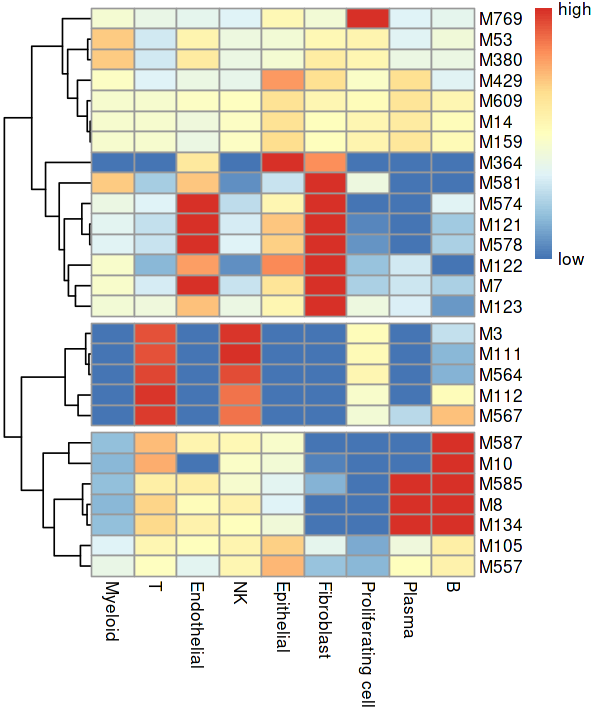

In [26]:
library(pheatmap)
options(repr.plot.height = 6, repr.plot.width = 5)
pheatmap(enrichScore,cluster_rows = T,cluster_cols = F,cutree_rows = 3,legend_breaks = c(-1, 1), legend_labels = c("low", "high"))

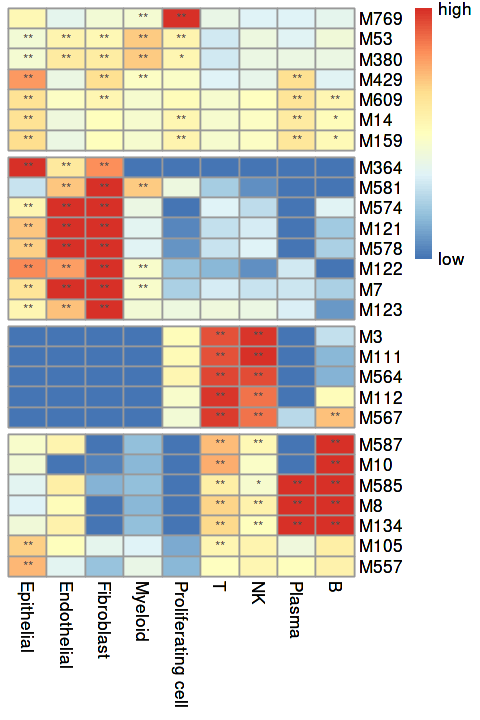

In [33]:
library(pheatmap)
options(repr.plot.height = 6, repr.plot.width = 4)
p1 <- pheatmap(enrichScore,cluster_rows = TRUE,display_numbers = ifelse(enrichScore_P <= 0.001, "**", ifelse(enrichScore_P<=0.01,'*','')),treeheight_row = 0,treeheight_col = 0,legend_breaks = c(-1, 1), legend_labels = c("low", "high"),cluster_cols = T,cutree_rows = 4)
p1

In [34]:
pdf(file = './output/bulk/section_2/GSE191301/0.OV_GSE191301_Single_moduleAUC_celltype.pdf',width = 4,height = 6)
print(p1)
dev.off()

png 
  2

In [49]:
saveRDS(OV_GSE191301,file = './output/OV_GSE191301.rds')

## 4.visualization

In [2]:
OV_GSE191301 <- readRDS(file = './output/OV_GSE191301.rds')

In [3]:
B_gene <- c('MS4A1','CD79A','CD83')
Plasma_gene <- c('DERL3','MZB1','JCHAIN')
DC_gene <- c('CD1E','CD1C')
T_gene <-c('CD3D','CD3E','CD8A','CD4','IL7R')
Epithelial_gene <-c('KRT19','KRT18','EPCAM')
myeloid_gene <-c('AIF1','CD14','FCER1G','FCGR3A')
Endothelial_gene <-c('RAMP2','VWF','SELE')
Fibroblasts_gene <- c('COL6A2','COL1A1','DCN')
mast_gene <- c('TPSAB1','TPSB2','CPA3')
NK_gene <- c('GNLY','KRT86')
proliferation<- c('MKI67','TOP2A')

cellMarker <- c(T_gene,NK_gene,Fibroblasts_gene,Epithelial_gene,myeloid_gene,B_gene,Plasma_gene,Endothelial_gene,proliferation)

In [4]:
OV_GSE191301$cellType_auto <- as.character(OV_GSE191301$cellType_auto)
table(OV_GSE191301$cellType_auto)


                 B               endo                Epi               fibo 
               503                239               5349                822 
           myeloid                 NK             plasma proliferating cell 
              9913               1779                 41               1130 
                 T 
             11601 

In [5]:
OV_GSE191301$cellType_auto <- factor(x=OV_GSE191301$cellType_auto,levels = c('T','NK','fibo','Epi','myeloid','B','plasma','endo','proliferating cell'),labels = c('T','NK','Fibroblast','Epithelial','Myeloid','B','Plasma','Endothelial','Proliferating cell'))

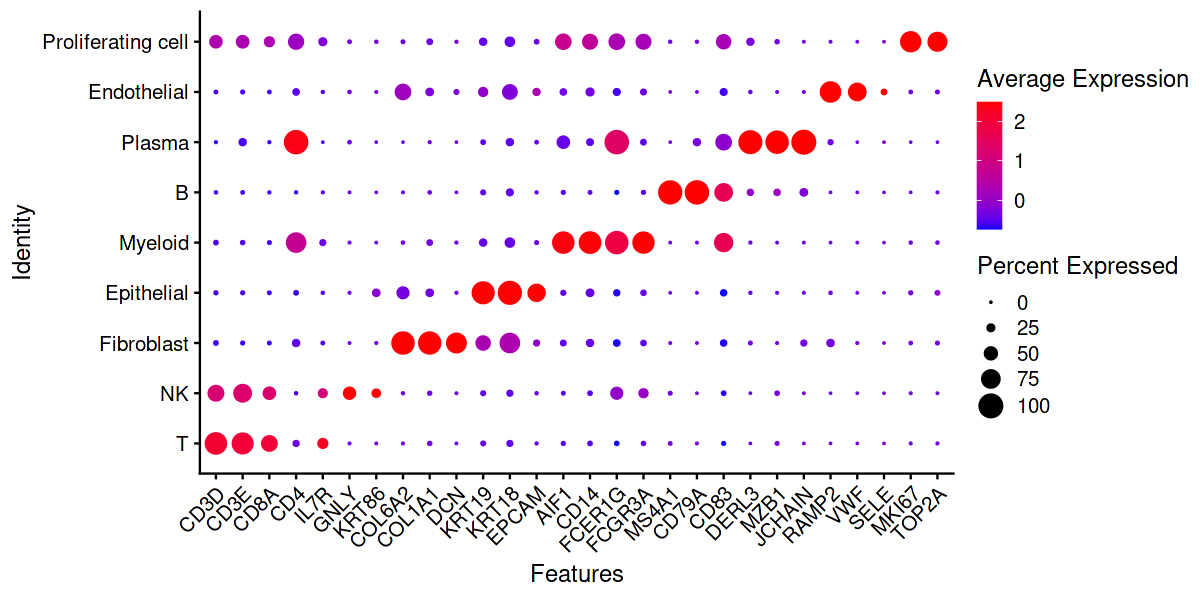

In [6]:
DefaultAssay(OV_GSE191301) <- 'RNA'
options(repr.plot.height = 5, repr.plot.width = 10)
dotp <- DotPlot(OV_GSE191301,group.by = 'cellType_auto',cols = c('blue','red'), features = unique(cellMarker),cluster.idents = F) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
dotp

In [7]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 9)

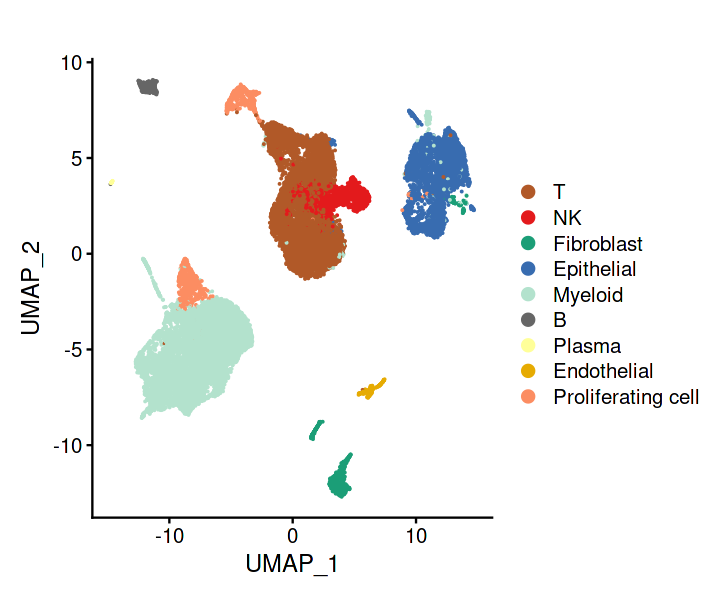

In [13]:
options(repr.plot.height = 5, repr.plot.width = 6)
dimplot <- DimPlot(object = OV_GSE191301,reduction = 'umap',group.by = c('cellType_auto'),cols = cellType_col, label = F)
dimplot <- dimplot+ggtitle("")
dimplot

In [11]:
pdf(file = './output/bulk/section_2/GSE191301/0.OV_GSE191301_Single_pre_dotplot.pdf',width = 10,height = 5)
print(dotp)
dev.off()

png 
  2

In [12]:
pdf(file = './output/bulk/section_2/GSE191301/0.OV_GSE191301_Single_pre.pdf',width = 6,height = 5)
print(dimplot)
dev.off()

png 
  2

## 5.immune cell extraction

In [43]:
DefaultAssay(OV_GSE191301) <- 'RNA'
table(OV_GSE191301$cellType_auto)


                 B               endo                Epi               fibo 
               503                239               5349                822 
           myeloid                 NK             plasma proliferating cell 
              9913               1779                 41               1130 
                 T 
             11601 

In [44]:
OV_GSE191301_immune <- subset(OV_GSE191301,cellType_auto %in% c('T','NK','myeloid','B','plasma'))

In [45]:
head(OV_GSE191301_immune)

,orig.ident,nCount_RNA,nFeature_RNA,mitoRatio,log10GenesPerUMI,riboRatio,RNA_snn_res.0.5,seurat_clusters,sampleId,cellType_auto,sample,patient_id
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
GSM5743307_AAACCCAGTCCGGCAT-1,GSM5743307,30948,4374,0.0395502133,0.8107719,3.955021e-04,2,2,GSM5743307,myeloid,GSM5743307,Pre-NACT-A
GSM5743307_AAACGAAGTATCGAAA-1,GSM5743307,8976,2534,0.0477941176,0.8610512,4.779412e-04,0,0,GSM5743307,T,GSM5743307,Pre-NACT-A
GSM5743307_AAACGAAGTCACTCTC-1,GSM5743307,2871,1345,0.1455938697,0.9047693,1.455939e-03,0,0,GSM5743307,T,GSM5743307,Pre-NACT-A
GSM5743307_AAACGAAGTGTGACCC-1,GSM5743307,6182,2220,0.0548366225,0.8826798,5.483662e-04,0,0,GSM5743307,T,GSM5743307,Pre-NACT-A
GSM5743307_AAACGCTAGGCCTTCG-1,GSM5743307,3042,840,0.0003287311,0.8395480,3.287311e-06,12,12,GSM5743307,myeloid,GSM5743307,Pre-NACT-A
GSM5743307_AAACGCTGTGATCGTT-1,GSM5743307,3968,1501,0.0594758065,0.8826782,5.947581e-04,0,0,GSM5743307,T,GSM5743307,Pre-NACT-A
GSM5743307_AAACGCTGTTCGGTAT-1,GSM5743307,7889,2042,0.1119280010,0.8493808,1.119280e-03,8,8,GSM5743307,myeloid,GSM5743307,Pre-NACT-A
GSM5743307_AAAGAACAGAGGTTAT-1,GSM5743307,9485,3007,0.1491829204,0.8745539,1.491829e-03,1,1,GSM5743307,myeloid,GSM5743307,Pre-NACT-A
GSM5743307_AAAGAACGTTTAGACC-1,GSM5743307,4277,1668,0.0659340659,0.8873788,6.593407e-04,0,0,GSM5743307,T,GSM5743307,Pre-NACT-A


In [46]:
OV_GSE191301_immune@meta.data <- OV_GSE191301_immune@meta.data[,c('orig.ident','nCount_RNA','nFeature_RNA','sample','patient_id','cellType_auto')]

In [47]:
OV_GSE191301_immune[['module_AUC']] <- NULL
OV_GSE191301_immune

An object of class Seurat 
27984 features across 23837 samples within 1 assay 
Active assay: RNA (27984 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, tsne

In [48]:
saveRDS(OV_GSE191301_immune,file = './output/OV_GSE191301_immune.rds')